In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data_loader import *
from src.helpers import *
from src.models.similarity_matrix import category_jaccard_similarity
import seaborn as sn
import matplotlib.pyplot as plt

parser = htmlParser()
parser.load_pickle()

# Section 1: some interesting results or statistics about the raw data

"complete all the necessary descriptive statistics tasks"
"show us that you have clear project goals"

- That you can handle the data in its size.
- That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

## Data Cleaning

- Steps done in data loader:

In [3]:
df_article_names = read_articles() 
df_html_stats = parser.get_df_html_stats()
df_categories = read_categories()
df_links = read_links()
df_shortest_path = read_shortest_path_matrix()
df_unfinished = read_unfinished_paths()
df_finished = read_finished_paths() 
df_sm = read_similartiy_matrix()
df_scat = category_jaccard_similarity(df_categories,{'level_1': 1, 'level_2': 2, 'level_3': 3})

Unfinished Paths 
Number of rows before filtering: 24875
Invalid target articles found: {'Fats', 'Long peper', ' Zebra', 'Great', 'Western Australia', 'Christmas', 'Georgia', 'Black ops 2', 'Netbook', 'Test', 'The Rock', 'The', 'Rat', 'Pikachu', 'Sportacus', 'Usa', 'Mustard', 'Kashmir', 'Adolph Hitler', 'Rss', 'Macedonia', 'Bogota', 'Charlottes web', 'Podcast', 'English'}
Invalid articles found in path: {'Pikachu', 'Wikipedia Text of the GNU Free Documentation License'}
Number of rows after filtering: 24721 

Finished Paths 
Number of rows before filtering: 51318
Invalid articles found in path: {'Pikachu', 'Wikipedia Text of the GNU Free Documentation License'}
Number of rows after filtering: 51210 



Computing Weighted Jaccard Similarity: 100%|██████████| 4597/4597 [00:07<00:00, 655.24it/s]


In [5]:
# let's add some useful metrics to each paths dataframe: shortest path, semantic similarity
df_unfinished['cosine_similarity'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_sm), axis=1)
df_unfinished['shortest_path'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_shortest_path), axis=1)
df_unfinished['path_length'] = df_unfinished['path'].apply(lambda x: x.count(';') + 1)
df_unfinished['back_clicks'] = df_unfinished['path'].apply(lambda x: x.count('<'))
df_unfinished["categories_similarity"] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_scat), axis=1)

df_finished['cosine_similarity'] = df_finished.apply(lambda x: find_shortest_distance(x, df_sm), axis=1)
df_finished['shortest_path'] = df_finished.apply(lambda x: find_shortest_distance(x, df_shortest_path), axis=1)
df_finished['path_length'] = df_finished['path'].apply(lambda x: x.count(';') + 1)
df_finished['back_clicks'] = df_finished['path'].apply(lambda x: x.count('<'))
df_finished["categories_similarity"] = df_finished.apply(lambda x: find_shortest_distance(x, df_scat), axis=1)

# and sort paths into voyage and not voyage
df_finished = voyage_sorting(df_finished, df_categories)
df_unfinished = voyage_sorting(df_unfinished, df_categories)

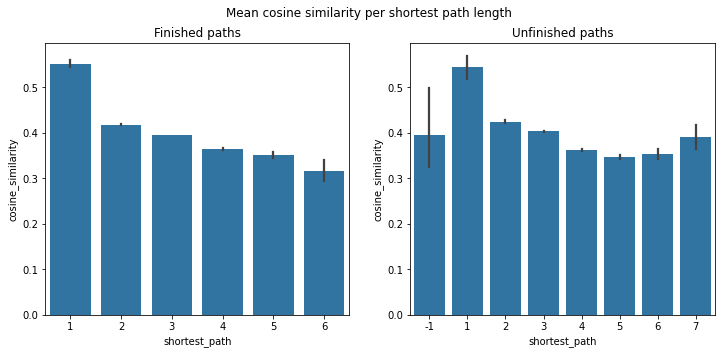

In [6]:
# note: -1 with no errorbar makes no sense. 1 with no error bar makes sense (trivial case where start=target and similarity with itself=1)

df_finished_clean = df_finished[df_finished['shortest_path'] != 0].copy()

plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
sn.barplot(data=df_finished_clean, x='shortest_path', y='cosine_similarity')
plt.title('Finished paths')

plt.subplot(122, sharey=ax)
sn.barplot(data=df_unfinished, x='shortest_path', y='cosine_similarity')
plt.title('Unfinished paths')

plt.suptitle('Mean cosine similarity per shortest path length')
plt.show()

In [7]:
from scipy.stats import pearsonr, spearmanr

def calculate_correlations_with_shortestPath(df, column_name):
    # Ensure 'shortest_path' is numeric
    df['shortest_path'] = df['shortest_path'].astype(float)

    pearson_corr, pearson_p = pearsonr(df['shortest_path'], df[column_name])
    spearman_corr, spearman_p = spearmanr(df['shortest_path'], df[column_name])

    # Print results
    print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4e}")
    print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4e}")

print('Finished paths:')
finished_results = calculate_correlations_with_shortestPath(df_finished_clean,"cosine_similarity")
print('\nUnfinished paths:')
unfinished_results = calculate_correlations_with_shortestPath(df_unfinished,"cosine_similarity")

Finished paths:
Pearson correlation: -0.2837, p-value: 0.0000e+00
Spearman correlation: -0.2359, p-value: 0.0000e+00

Unfinished paths:
Pearson correlation: -0.2732, p-value: 0.0000e+00
Spearman correlation: -0.2752, p-value: 0.0000e+00


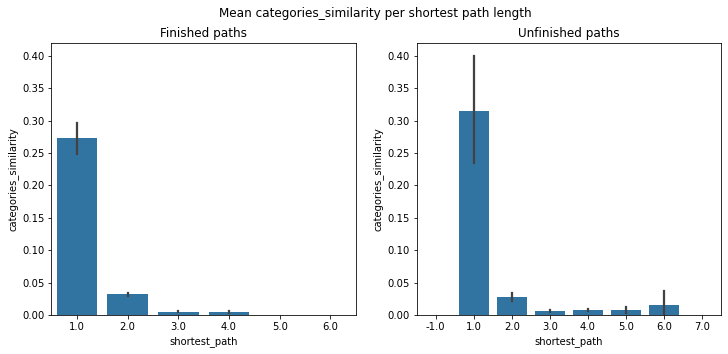

In [8]:
# note: -1 with no errorbar makes no sense. 1 with no error bar makes sense (trivial case where start=target and similarity with itself=1)
# impossible paths in unfinishes paths are possible however. check if it is sound though because of the previous problem.

plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
sn.barplot(data=df_finished_clean, x='shortest_path', y='categories_similarity')
plt.title('Finished paths')

plt.subplot(122, sharey=ax)
sn.barplot(data=df_unfinished, x='shortest_path', y='categories_similarity')
plt.title('Unfinished paths')

plt.suptitle('Mean categories_similarity per shortest path length')
plt.show()

In [9]:
print('Finished paths:')
finished_results = calculate_correlations_with_shortestPath(df_finished_clean,"categories_similarity")
print('\nUnfinished paths:')
unfinished_results = calculate_correlations_with_shortestPath(df_unfinished,"categories_similarity")

Finished paths:
Pearson correlation: -0.1968, p-value: 0.0000e+00
Spearman correlation: -0.1938, p-value: 0.0000e+00

Unfinished paths:
Pearson correlation: -0.0762, p-value: 3.5193e-33
Spearman correlation: -0.0816, p-value: 8.5774e-38


- Pearson Correlation
Measures the linear relationship between two continuous variables.

- Spearman Correlation
Assesses the monotonic relationship using ranked data, making it less sensitive to outliers and non-linear relationships.

The p-values are effectively zero, which is highly significant statistically. This suggests that the observed correlations are unlikely to be due to random chance.

-> Thus as the distance path increase, the cosine_similarity decrease
In other words...

### Difficulty measure
Find patterns in user behaviour and try to understand how we could measure whether a game was difficult or not

The mean duration of finished paths is 158 seconds
The mean duration of unfinished paths is 836 seconds


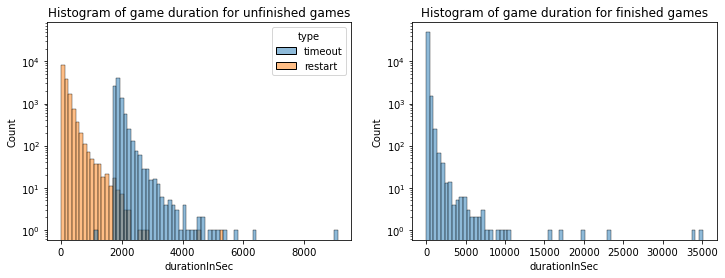

In [10]:
# REMOVE OUTLIERS THAT MAKE NO SENSE

#df_game_durations = pd.concat([df_finished[['durationInSec', 'type']], df_unfinished[['durationInSec', 'type']]], ignore_index=True)
print(f"The mean duration of finished paths is {df_finished['durationInSec'].mean():.0f} seconds")
print(f"The mean duration of unfinished paths is {df_unfinished['durationInSec'].mean():.0f} seconds")

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)
sn.histplot(df_unfinished, x='durationInSec', hue='type', bins=75)
plt.yscale('log')
plt.title('Histogram of game duration for unfinished games')

plt.subplot(122, sharey = ax1)
sn.histplot(df_finished, x='durationInSec', bins=75, alpha=0.5)
plt.yscale('log')
plt.title('Histogram of game duration for finished games')
plt.show()

In [11]:
sorted = df_unfinished[df_unfinished['type']=='timeout']['durationInSec'].sort_values()
sorted

13318    1129
12327    1768
3941     1777
6708     1778
1278     1784
         ... 
7050     5188
19141    5360
21503    5716
2800     6413
4222     9089
Name: durationInSec, Length: 9273, dtype: int64

In [12]:
sorted = df_finished['durationInSec'].sort_values(ascending=False)
sorted

10845    35091
48968    34009
23493    23326
23007    19740
43547    17171
         ...  
34275        0
30737        0
38894        0
9862         0
50359        0
Name: durationInSec, Length: 51210, dtype: int64

In [13]:

df_path_stats_duration = pd.DataFrame()
df_path_stats_duration['mean'] = df_finished.groupby('rating', dropna=False)['durationInSec'].mean()
df_path_stats_duration['std'] = df_finished.groupby('rating', dropna=False)['durationInSec'].std()
df_path_stats_duration['sem'] = df_finished.groupby('rating', dropna=False)['durationInSec'].sem()


df_path_stats_length = pd.DataFrame()
df_path_stats_length['mean'] = df_finished.groupby('rating', dropna=False)['path_length'].mean()
df_path_stats_length['std'] = df_finished.groupby('rating', dropna=False)['path_length'].std()
df_path_stats_length['sem'] = df_finished.groupby('rating', dropna=False)['path_length'].sem()


df_path_stats = pd.concat([df_path_stats_duration, df_path_stats_length], axis=1, keys=['duration', 'length'])

df_path_stats

duration                            length                     
              mean         std        sem       mean        std       sem
rating                                                                   
1.0      80.150609  152.273618   1.648539   4.664909   2.052327  0.022219
2.0     137.036683  311.602204   3.325851   5.996355   2.432872  0.025967
3.0     195.863962  296.518511   3.482914   7.640866   3.706646  0.043538
4.0     281.351095  359.639492   6.870559  10.079927   5.871245  0.112164
5.0     368.231304  463.405289  13.665076  13.237391  17.200507  0.507215
NaN     158.053993  430.555836   2.853805   6.815218   4.031546  0.026722

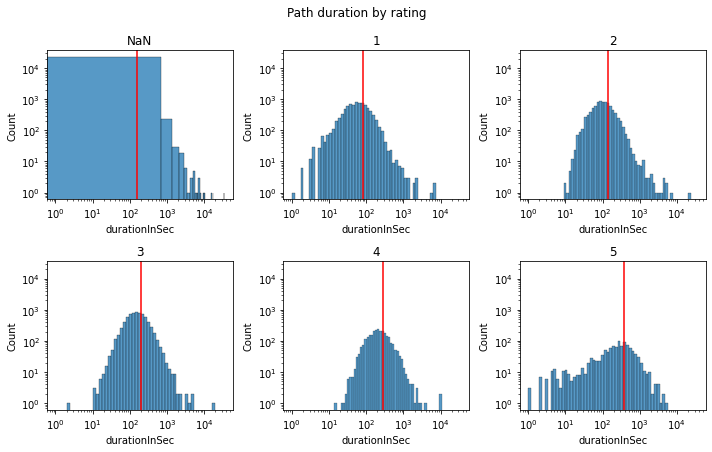

In [14]:
# Those are some nice log-normal distributions -> are they though? the distribution is normal in loglog, not log.
# except for NaN, there is a steady increase of the path duration mean when rating goes up

plt.figure(figsize=(10, 6))


means, stds = [], []
ax1 = plt.subplot(231)
sn.histplot(df_finished[df_finished['rating'].isnull()], x='durationInSec', bins=50) # change x to x = 'path_length' for path length
means.append(df_finished[df_finished['rating'].isnull()]['durationInSec'].mean())
stds.append(df_finished[df_finished['rating'].isnull()]['durationInSec'].std())
plt.axvline(means[0], color='red')
plt.yscale('log')
plt.xscale('log')
plt.title('NaN')


for i in range(1, 6):
    plt.subplot(231+i, sharex = ax1, sharey=ax1)
    means.append(df_finished[df_finished['rating']==i]['durationInSec'].mean())
    stds.append(df_finished[df_finished['rating']==i]['durationInSec'].std())
    sn.histplot(df_finished[df_finished['rating']==i], x='durationInSec', bins=50)
    plt.axvline(means[i], color='red')
    plt.yscale('log')
    plt.xscale('log')
    plt.title(i)

plt.tight_layout()
plt.suptitle('Path duration by rating', y=1.04)
plt.show()

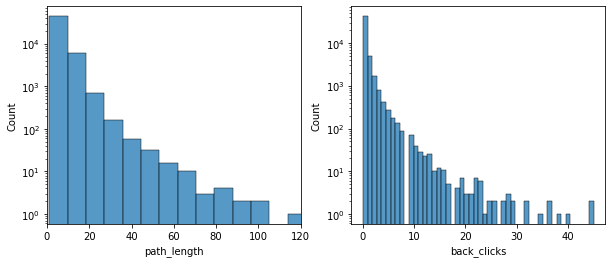

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
sn.histplot(df_finished, x='path_length', bins=50)
plt.yscale('log')
plt.xlim(0, 120)

plt.subplot(122)
sn.histplot(df_finished, x='back_clicks', bins=50)
plt.yscale('log')

### Categories distribution in start and end paths between finished and unfinished games

In [16]:
paths_finished = find_categories_start_end(df_finished, df_categories)
paths_unfinished = find_categories_start_end(df_unfinished, df_categories)

paths_finished["finished"] = 1
paths_unfinished["finished"] = 0

paths = pd.concat([paths_finished, paths_unfinished], join='inner')
paths_melted = paths.melt(
    id_vars=["finished"],
    value_vars=["start_category", "end_category"],
    var_name="category_type",
    value_name="category"
)

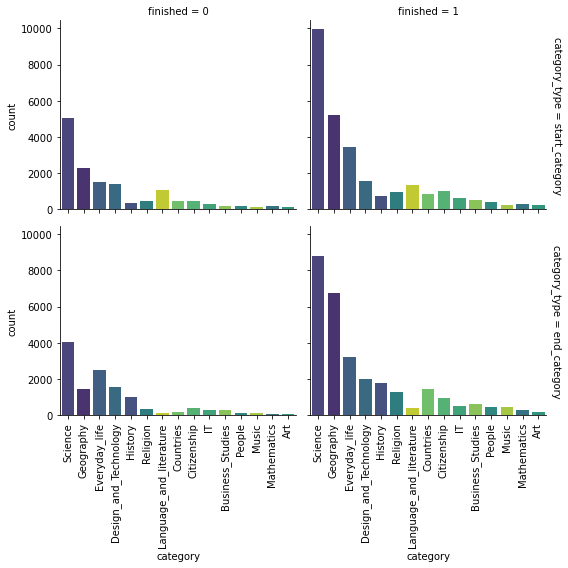

In [31]:
# Create a color palette based on unique categories
unique_categories = paths_melted['category'].unique()
palette = sn.color_palette("viridis", n_colors=len(unique_categories))
color_mapping = dict(zip(unique_categories, palette))

g = sn.FacetGrid(
    data=paths_melted,
    col="finished",
    row="category_type",
    sharey=True,
    sharex=True,
    margin_titles=True,
    height=4,
)

g.map_dataframe(
    sn.countplot,
    x="category",
    hue="category",
    palette=color_mapping,
    order=paths_melted['category'].value_counts().index  # Order by frequency
)

# Rotate x-axis labels for readability
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()
plt.show()


### Comparison of duration of path between starting subject and ending subject

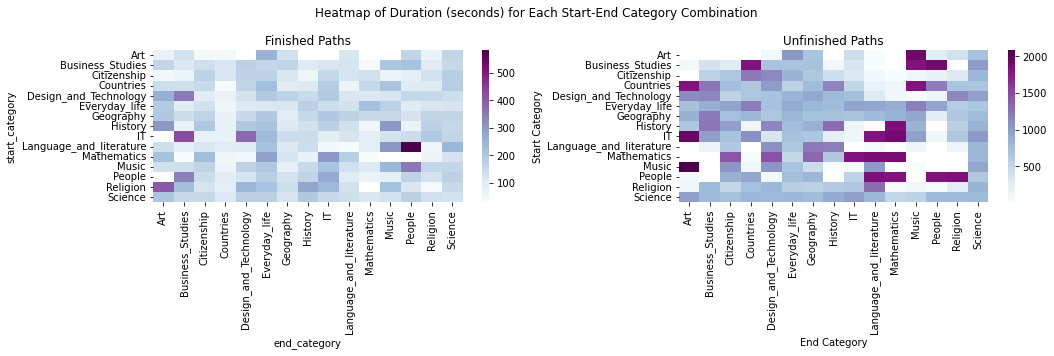

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='durationInSec', 
                                                    aggfunc='mean')
path_unfinished_length_categories = paths_unfinished.pivot_table(index='start_category',
                                                    columns='end_category',
                                                    values='durationInSec',
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='BuPu', ax=ax[0])
sn.heatmap(path_unfinished_length_categories , cmap='BuPu', ax=ax[1])
ax[0].set_title("Finished Paths")
ax[1].set_title("Unfinished Paths")
fig.suptitle("Heatmap of Duration (seconds) for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

### Comparison of length of path between starting subject and ending subject

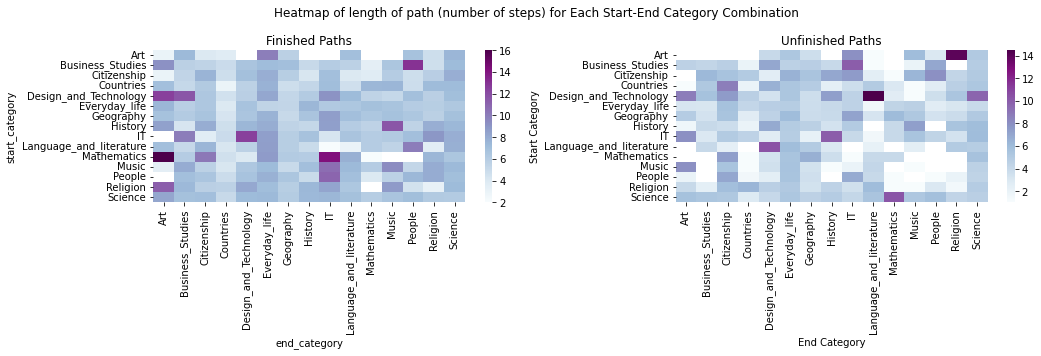

In [33]:
paths_finished["steps_count"] = paths_finished["path"].apply(lambda x: len(x.split(";")))
paths_unfinished["steps_count"] = paths_unfinished["path"].apply(lambda x: len(x.split(";")))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='steps_count', 
                                                    aggfunc='mean')
path_unfinished_length_categories = paths_unfinished.pivot_table(index='start_category',
                                                    columns='end_category',
                                                    values='steps_count',
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='BuPu', ax=ax[0])
sn.heatmap(path_unfinished_length_categories , cmap='BuPu', ax=ax[1])
ax[0].set_title("Finished Paths")
ax[1].set_title("Unfinished Paths")
fig.suptitle("Heatmap of length of path (number of steps) for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

### Comparison of rating between starting subject and ending subject

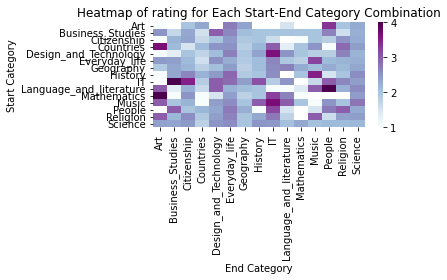

In [34]:
path_finished_length_categories = paths_finished.pivot_table(index='start_category', 
                                                    columns='end_category', 
                                                    values='rating', 
                                                    aggfunc='mean')

sn.heatmap(path_finished_length_categories , cmap='BuPu')
plt.title("Heatmap of rating for Each Start-End Category Combination")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.tight_layout()
plt.show()

### Correlation between the rating, the backclip number and the topics

In [35]:
df_categories_filtered = filter_most_specific_category(df_categories)
paths_finished = extract_category_path(df_finished, df_categories_filtered)
paths_finished = backtrack(paths_finished)

NameError: name 'extract_category_path' is not defined

NameError: name 'paths_finished' is not defined

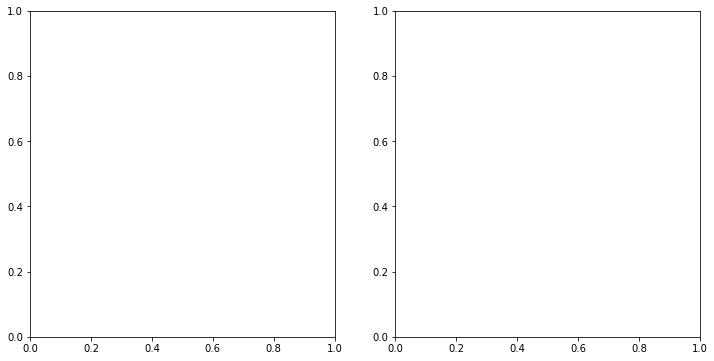

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

back_per_rating = paths_finished.groupby("rating").agg({"back_nb": "mean", "size": "mean"}).reset_index()
back_per_rating['Mean Back Clicks number'] = back_per_rating["back_nb"]/back_per_rating["size"]
sn.barplot(x="rating", y='Mean Back Clicks number', hue="rating", data=back_per_rating, palette="viridis", ax=ax[0])

df_exploded = paths_finished.explode('category')
category_back_mean = df_exploded.groupby('category')["have_back"].mean().reset_index().sort_values(by='have_back', ascending=False)
sn.barplot(data=category_back_mean, x='category', y='have_back', palette='viridis', ax=ax[1])
plt.title('Mean Number of Back Clicks by Category')
plt.xlabel('Category')
plt.ylabel('Mean Number of Path with Back Clicks')
plt.xticks(rotation=90)
plt.show()